## Import

In [1]:
import sys,glob,datetime,os,gc,cftime
import xarray as xr
import xesmf as xe
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

sys.path.append('/home/u/u290372/scripts/preprocesseing_levante/')
import _pre_oneRun as _pre_oneRun

ACCESS-ESM1-5 CESM2-WACCM CanESM5 EC-Earth3
       EC-Earth3-Veg-LR FGOALS-g3 GFDL-ESM4 GISS-E2-1-G
       IPSL-CM6A-LR MIROC-ES2L MIROC6 MPI-ESM1-2-LR
       MRI-ESM2-0 UKESM1-0-LL

In [45]:
try:
    %matplotlib inline
    %load_ext autoreload
    %autoreload 2
    indicator = 'tos'
    realm = 'Omon'
    esm = 'MIROC-ES2L'
    scenario = 'ssp534-over' 
    
except:
    import argparse
    parser = argparse.ArgumentParser(description='look it up')
    parser.add_argument('-i', '--indicator')  
    parser.add_argument('-s', '--scenario')  
    parser.add_argument('-m', '--esm')  
    parser.add_argument('-r', '--realm')  
    args = vars(parser.parse_args())
    print(args)
    indicator = args['indicator']   
    scenario = args['scenario']   
    esm = args['esm']   
    realm = args['realm']
print(esm, indicator)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
MIROC-ES2L tos


In [46]:
if os.path.isdir('/work/uc1275/u290372/overshoot/gridded_period_averages/%s/' %(indicator)) == False:
    os.system('mkdir /work/uc1275/u290372/overshoot/gridded_period_averages/%s/' %(indicator))

In [47]:
if realm == 'ETCCDI':
    search_strings = ['/work/uc1275/u290372/data/etccdi_indices_*/INDICATOR_mon_ESM_SCENARIO_RUN_*.nc']
else:
    search_strings = ['/pool/data/CMIP6/data/*/*/ESM/SCENARIO/RUN/REALM/INDICATOR/*/*/*',
                      '/work/uc1275/u290372/CMIP6/data/*/*/ESM/SCENARIO/RUN/REALM/INDICATOR/*/*/*']

SMRs = []
for search_string in search_strings:
    dummy = _pre_oneRun.oneRun(scenario=scenario,esm=esm,run='*',realm=realm,indicator=indicator, search_strings=search_strings, source='CMIP6')
    if 'ETCCDI' in indicator:
        SMRs += ['_'.join([msr.split('_')[-3], msr.split('_')[-4], msr.split('_')[-2]]) for msr in dummy.get_files(search_string)]
    else:
        MSRs = np.unique([fl.split(realm+'_')[-1].split('_g')[0] for fl in dummy.get_files(search_string)])
        SMRs += ['_'.join([msr.split('_')[1], msr.split('_')[0], msr.split('_')[2]]) for msr in MSRs]
SMRs = np.unique(SMRs)

In [48]:
SMRs

array(['ssp534-over_MIROC-ES2L_r1i1p1f2'], dtype='<U31')

In [49]:
ds_regrid = xr.Dataset({'lat': (['lat'], np.arange(-90,91,1)),
                        'lon': (['lon'], np.arange(-178,181,1)),})

In [55]:
l = []
for smr in SMRs:
    scenario,esm,run = smr.split('_')
    fl = '/work/uc1275/u290372/overshoot/regional/%s/Amon/tas/global/CMIP6_Amon_tas_%s_global_annual-mean.nc' %('CMIP6', smr)
    gmt = xr.load_dataset(fl)['tas']
    gmt = gmt.rolling(year=31, center=True).mean('year') 
    
    gmt -= gmt.max()
    if np.all(np.isfinite(gmt.loc[2030:2080])):
        peak_year = gmt.year.values[np.nanargmax(gmt)]
        # closest years to -0.2 ,0.1, peak, -0.1, -0.2
        candidate_years = np.array([
            gmt.loc[:peak_year].year.values[np.nanargmin(np.abs(gmt.loc[:peak_year] + 0.2))],
            gmt.loc[:peak_year].year.values[np.nanargmin(np.abs(gmt.loc[:peak_year] + 0.1))],
            peak_year,
            gmt.loc[peak_year:].year.values[np.nanargmin(np.abs(gmt.loc[peak_year:] + 0.1))],
            gmt.loc[peak_year:].year.values[np.nanargmin(np.abs(gmt.loc[peak_year:] + 0.2))]
        ])   

        # check whether candidate years are close enough
        relevant_years = candidate_years.copy() + 0.0
        for i,yr,v in zip(range(5),candidate_years,[-0.2,-0.1,0,-0.1,-0.2]):
            if np.abs(gmt.loc[yr] - v) > 0.05:
                relevant_years[i] = np.nan

        # only continue if the required warming levels are there
        if len(relevant_years) > 3:
            full_grid = _pre_oneRun.oneRun(scenario=scenario,esm=esm,run=run,realm=realm,indicator=indicator, 
                                           search_strings=search_strings, source='CMIP6')
            full_grid.open_data()

            y = full_grid._data.groupby('time.year').mean('time')

            ps = xr.DataArray(dims=['SMR','period','lat','lon'], 
                  coords=dict(SMR=[smr], 
                              period=['-0.2b','-0.1b','oshoot','-0.1a','-0.2a'], 
                              lat=ds_regrid.lat.values, 
                              lon=ds_regrid.lon.values))  
                
            for i,yr in enumerate(relevant_years):
                if np.isfinite(yr):
                    tmp = y.loc[yr-15:yr+15].mean('year').load()
                    for method in ['conservative','bilinear']:
                        try:
                            regridder = xe.Regridder(tmp, ds_regrid, method, ignore_degenerate=True, periodic=True)
                            tmp = regridder(tmp)
                            ps.loc[smr][i,:,:] = tmp
                        except:
                            print(smr,method)
                              
            l.append(ps)
            xr.Dataset({indicator:xr.concat(l, dim='SMR')}).to_netcdf(
                '/work/uc1275/u290372/overshoot/gridded_period_averages/%s/%s_%s_31year_periods.nc' %(indicator, esm, scenario))

            

ssp534-over_MIROC-ES2L_r1i1p1f2 conservative
ssp534-over_MIROC-ES2L_r1i1p1f2 conservative
ssp534-over_MIROC-ES2L_r1i1p1f2 conservative
ssp534-over_MIROC-ES2L_r1i1p1f2 conservative
ssp534-over_MIROC-ES2L_r1i1p1f2 conservative


In [38]:
xr.Dataset({indicator:xr.concat(l, dim='SMR')}).to_netcdf(
                '/work/uc1275/u290372/overshoot/gridded_period_averages/%s/%s_%s_31year_periods.nc' %(indicator, esm, scenario))

In [23]:
SMRs

['ssp119_EC-Earth3_r4i1p1f1',
 'ssp119_EC-Earth3_r101i1p1f1',
 'ssp119_EC-Earth3_r102i1p1f1',
 'ssp119_EC-Earth3_r103i1p1f1',
 'ssp119_EC-Earth3_r104i1p1f1',
 'ssp119_EC-Earth3_r105i1p1f1',
 'ssp119_EC-Earth3_r106i1p1f1',
 'ssp119_EC-Earth3_r107i1p1f1',
 'ssp119_EC-Earth3_r108i1p1f1',
 'ssp119_EC-Earth3_r109i1p1f1',
 'ssp119_EC-Earth3_r110i1p1f1',
 'ssp119_EC-Earth3_r111i1p1f1',
 'ssp119_EC-Earth3_r112i1p1f1',
 'ssp119_EC-Earth3_r113i1p1f1',
 'ssp119_EC-Earth3_r114i1p1f1',
 'ssp119_EC-Earth3_r115i1p1f1',
 'ssp119_EC-Earth3_r116i1p1f1',
 'ssp119_EC-Earth3_r117i1p1f1',
 'ssp119_EC-Earth3_r118i1p1f1',
 'ssp119_EC-Earth3_r119i1p1f1',
 'ssp119_EC-Earth3_r120i1p1f1',
 'ssp119_EC-Earth3_r121i1p1f1',
 'ssp119_EC-Earth3_r122i1p1f1',
 'ssp119_EC-Earth3_r123i1p1f1',
 'ssp119_EC-Earth3_r124i1p1f1',
 'ssp119_EC-Earth3_r125i1p1f1',
 'ssp119_EC-Earth3_r126i1p1f1',
 'ssp119_EC-Earth3_r127i1p1f1',
 'ssp119_EC-Earth3_r128i1p1f1',
 'ssp119_EC-Earth3_r129i1p1f1',
 'ssp119_EC-Earth3_r130i1p1f1',
 'ssp119_E

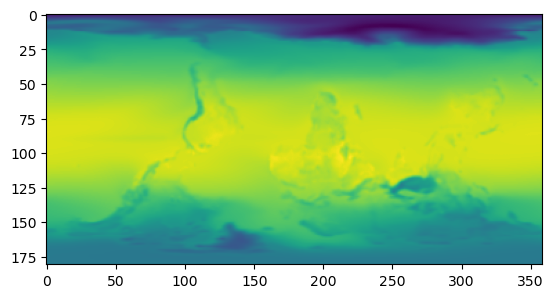

In [14]:
import matplotlib.pyplot as plt
plt.imshow(xr.concat(l, dim='SMR').mean('SMR')[2])

In [ ]:
ds_regrid = xr.Dataset({
    'lon': (['lon'], np.arange(-180,180+1, 1,'int')),
    'lat': (['lat'], np.arange(-89.5,90.5,1,'int')),})

regridder = xe.Regridder(y, ds_regrid, 'bilinear', ignore_degenerate=True, periodic=True)
var = regridder(y).compute()

ValueError: The truth value of a Array is ambiguous. Use a.any() or a.all().